<a href="https://colab.research.google.com/github/irawan09/EventHistoryAnalysis/blob/main/Event_history_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library Preparation

In [1]:
!pip install kaplanmeier
!pip install lifelines
!pip install julian

     |████████████████████████████████| 358kB 5.3MB/s 
     |████████████████████████████████| 61kB 5.1MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp37-none-any.whl size=4050 sha256=b124105368eb13593b45123f5f4373522150821c3324edae89e46842d4b1e93a
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma
  Created wheel for julian: filename=julian-0.14-cp37-none-any.whl size=2634 sha256=592077f561fc57421a3dbfccb6cb2e69659a28636eea314c8363404fa4af316d
  Stored in directory: /root/.cache/pip/wheels/ce/b7/8a/aa742c5ae0a627cc1a665f14550988c012f8c38fc15c2f80b9
Successfully built julian


In [2]:
!git clone 'https://github.com/irawan09/EventHistoryAnalysis.git'

Cloning into 'EventHistoryAnalysis'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 2), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [3]:
import kaplanmeier as km
import julian as js
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import (KaplanMeierFitter, 
                       CoxPHFitter, 
                       WeibullAFTFitter, 
                       LogNormalAFTFitter, 
                       LogLogisticAFTFitter)
from lifelines.statistics import (logrank_test, 
                                  pairwise_logrank_test, 
                                  multivariate_logrank_test, 
                                  survival_difference_at_fixed_point_in_time_test)

#Data Preprocessing

In [5]:
import pandas as pd

df = pd.read_excel (r'/content/EventHistoryAnalysis/Aids.xls')
df.head()

,Unnamed: 0,state,sex,diag,death,status,T.categ,age
0,1,NSW,M,10905,11081,D,hs,35
1,2,NSW,M,11029,11096,D,hs,53
2,3,NSW,M,9551,9983,D,hs,42
3,4,NSW,M,9577,9654,D,haem,44
4,5,NSW,M,10015,10290,D,hs,39


In [6]:
new_data = []
for data in df.diag:
    data = js.from_jd(data, fmt='mjd')
    new_data.append(data)

df.insert(4, "greg_diag", new_data, True)
df.head()

,Unnamed: 0,state,sex,diag,greg_diag,death,status,T.categ,age
0,1,NSW,M,10905,1888-09-25,11081,D,hs,35
1,2,NSW,M,11029,1889-01-27,11096,D,hs,53
2,3,NSW,M,9551,1885-01-10,9983,D,hs,42
3,4,NSW,M,9577,1885-02-05,9654,D,haem,44
4,5,NSW,M,10015,1886-04-19,10290,D,hs,39


In [7]:
new_data_death = []
for data_death in df.death:
    data_death = js.from_jd(data_death, fmt='mjd')
    new_data_death.append(data_death)

df.insert(6, "greg_death", new_data_death, True)
df.head()

,Unnamed: 0,state,sex,diag,greg_diag,death,greg_death,status,T.categ,age
0,1,NSW,M,10905,1888-09-25,11081,1889-03-20,D,hs,35
1,2,NSW,M,11029,1889-01-27,11096,1889-04-04,D,hs,53
2,3,NSW,M,9551,1885-01-10,9983,1886-03-18,D,hs,42
3,4,NSW,M,9577,1885-02-05,9654,1885-04-23,D,haem,44
4,5,NSW,M,10015,1886-04-19,10290,1887-01-19,D,hs,39


In [8]:
df['duration'] = df["greg_death"] - df["greg_diag"]
df['duration'] = df.apply(lambda row: row.duration.days, axis=1)
df.head()

,Unnamed: 0,state,sex,diag,greg_diag,death,greg_death,status,T.categ,age,duration
0,1,NSW,M,10905,1888-09-25,11081,1889-03-20,D,hs,35,176
1,2,NSW,M,11029,1889-01-27,11096,1889-04-04,D,hs,53,67
2,3,NSW,M,9551,1885-01-10,9983,1886-03-18,D,hs,42,432
3,4,NSW,M,9577,1885-02-05,9654,1885-04-23,D,haem,44,77
4,5,NSW,M,10015,1886-04-19,10290,1887-01-19,D,hs,39,275


In [9]:
# Create dummy variables
df_dummy = pd.get_dummies(df, drop_first=True)
df_dummy.head()

# df_dummy.to_csv(r'/content/event_history_analysis/Aids.csv', index = False)

,Unnamed: 0,diag,greg_diag,death,greg_death,age,duration,state_Other,state_QLD,state_VIC,sex_M,status_D,T.categ_haem,T.categ_het,T.categ_hs,T.categ_hsid,T.categ_id,T.categ_mother,T.categ_other
0,1,10905,1888-09-25,11081,1889-03-20,35,176,0,0,0,1,1,0,0,1,0,0,0,0
1,2,11029,1889-01-27,11096,1889-04-04,53,67,0,0,0,1,1,0,0,1,0,0,0,0
2,3,9551,1885-01-10,9983,1886-03-18,42,432,0,0,0,1,1,0,0,1,0,0,0,0
3,4,9577,1885-02-05,9654,1885-04-23,44,77,0,0,0,1,1,1,0,0,0,0,0,0
4,5,10015,1886-04-19,10290,1887-01-19,39,275,0,0,0,1,1,0,0,1,0,0,0,0


In [10]:
#Check the dataset if there is a null value
df_dummy.isnull().values.any()

False

#Kaplan-Meier Estimator

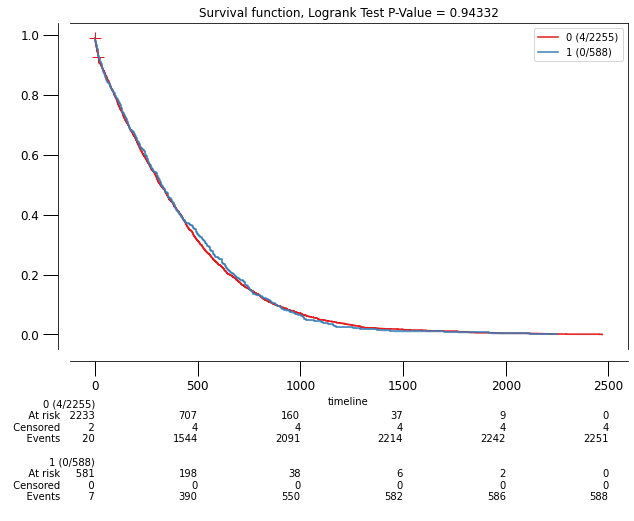

In [11]:
time_event=df_dummy['duration']
censoring=df_dummy['age'] 
data_1=df_dummy['T.categ_mother']
data_2=df_dummy['state_VIC']

# Compute survival
out=km.fit(time_event, censoring, data_2)

km.plot(out)

In [12]:
results = pairwise_logrank_test(time_event, censoring, data_2)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
       test_statistic      p  -log2(p)
0  1             0.67   0.41      1.27
   3             0.00   1.00     -0.00
   5             0.00   1.00     -0.00
   6             0.00   1.00     -0.00
   9             0.00   1.00     -0.00
   11            0.00   1.00     -0.00
   12            0.00   1.00     -0.00
   13            0.00   1.00     -0.00
   14            0.00   1.00     -0.00
   15            0.00   1.00     -0.00
   16            0.00   1.00     -0.00
   17            0.00   1.00     -0.00
   18            0.00   1.00     -0.00
   19            0.00   1.00     -0.00
   20            0.00   1.00     -0.00
   21            0.00   1.00     -0.00
   22            0.00   1.00     -0.00
   23            0.07   0.79      0.33
   24            0.00   1.00     -0.00
   25            0.08   0.78      0.36
   26            0.02   0.88      0.19
   27            0.05   0.83      0.27
   28            0.00   1.00     -0.00
   29            0.04   0.85      0.23
   30            0.00   1.00     -0.00
   31            0.00   1.00     -0.00
   32            0.00   1.00     -0.00
   33            0.09   0.76      0.39
   34            0.02   0.89      0.16
   35            0.02   0.89      0.16
   36            0.06   0.81      0.31
   37            0.00   1.00     -0.00
   38            0.00   1.00     -0.00
   39            0.08   0.78      0.37
   40            0.02   0.88      0.18
   41            0.00   1.00     -0.00
   42            0.00   1.00     -0.00
   43            0.12   0.72      0.47
   44            0.06   0.81      0.30
   45            0.00   1.00     -0.00
   46            0.10   0.76      0.40
   47            0.00   1.00     -0.00
   48            0.08   0.78      0.37
   49            0.00   1.00     -0.00
   50            0.06   0.81      0.30
   51            0.00   1.00     -0.00
   52            0.00   1.00     -0.00
   53            0.08   0.78      0.36
   54            0.00   1.00     -0.00
   55            0.10   0.75      0.41
   56            0.00   1.00     -0.00
   57            0.13   0.72      0.48
   58            0.00   1.00     -0.00
   59            0.00   1.00     -0.00
   60            0.00   1.00     -0.00
   61            0.33   0.56      0.83
   62            0.00   1.00     -0.00
   63            0.00   1.00     -0.00
   64            0.00   1.00     -0.00
   65            0.00   1.00     -0.00
   66            0.36   0.55      0.87
   67            0.00   1.00     -0.00
   68            0.00   1.00     -0.00
   69            0.00   1.00     -0.00
   70            0.00   1.00     -0.00
   71            0.00   1.00     -0.00
   72            0.00   1.00     -0.00
   73            0.00   1.00     -0.00
   74            0.00   1.00     -0.00
   77            0.00   1.00     -0.00
   78            0.00   1.00     -0.00
   80            0.00   1.00     -0.00
   82            0.00   1.00     -0.00
1  3             0.67   0.41      1.27
   5             1.00   0.32      1.66
   6             0.67   0.41      1.27
   9             0.33   0.56      0.83
   11            0.00   1.00     -0.00
   12            1.00   0.32      1.66
   13            0.33   0.56      0.83
   14            0.67   0.41      1.27
   15            1.00   0.32      1.66
   16            1.00   0.32      1.66
   17            1.00   0.32      1.66
   18            1.00   0.32      1.66
   19            0.67   0.41      1.27
   20            2.00   0.16      2.67
   21            4.00   0.05      4.46
   22            5.33   0.02      5.58
   23            3.80   0.05      4.29
   24            8.53 <0.005      8.16
   25            7.15   0.01      7.06
   26            4.08   0.04      4.53
   27            2.58   0.11      3.20
   28            4.49   0.03      4.88
   29            5.46   0.02      5.68
   30           13.09 <0.005     11.72
   31          

In [13]:
result = logrank_test(time_event, censoring, data_2)
result.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        5879.61 <0.005       inf

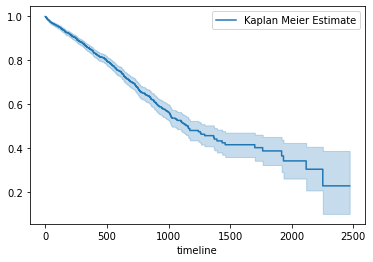

In [14]:
censoring_1=df_dummy['state_VIC'] 

kmf = KaplanMeierFitter() 
kmf.fit(time_event, censoring_1,label='Kaplan Meier Estimate')

kmf.plot(ci_show=True)
## ci_show is meant for Confidence interval, since our data set is too tiny, thus i am not showing it.

In [15]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0,29,7,22,2843,2843
1,20,1,19,0,2814
2,16,3,13,0,2794
3,13,2,11,0,2778
4,10,1,9,0,2765
...,...,...,...,...,...
2228,1,0,1,0,5
2252,1,1,0,0,4
2295,1,0,1,0,3


#COX Proportional Hazards Model

In [16]:
selected_columns = df_dummy[['diag', 'death',	'age',	'duration',	'state_Other',	
                             'state_QLD',	'state_VIC',	'sex_M',	'status_D',	
                             'T.categ_haem', 'T.categ_het', 'T.categ_hs', 'T.categ_hsid', 
                             'T.categ_id', 'T.categ_mother', 'T.categ_other'
                             ]
                            ]

new_df = selected_columns.copy()
new_df.head()

,diag,death,age,duration,state_Other,state_QLD,state_VIC,sex_M,status_D,T.categ_haem,T.categ_het,T.categ_hs,T.categ_hsid,T.categ_id,T.categ_mother,T.categ_other
0,10905,11081,35,176,0,0,0,1,1,0,0,1,0,0,0,0
1,11029,11096,53,67,0,0,0,1,1,0,0,1,0,0,0,0
2,9551,9983,42,432,0,0,0,1,1,0,0,1,0,0,0,0
3,9577,9654,44,77,0,0,0,1,1,1,0,0,0,0,0,0
4,10015,10290,39,275,0,0,0,1,1,0,0,1,0,0,0,0


In [17]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(new_df, 'duration', event_col='age')
cph.print_summary()

/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column T.categ_haem have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['age'].astype(bool)
>>> print(df.loc[events, 'T.categ_haem'].var())
>>> print(df.loc[~events, 'T.categ_haem'].var())

A very low variance means that the column T.categ_haem completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/lifelines/fitters/coxph_fitter.py:1603: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergenc

<lifelines.CoxPHFitter: fitted with 2843 total observations, 4 right-censored observations>
             duration col = 'duration'
                event col = 'age'
      baseline estimation = breslow
   number of observations = 2843
number of events observed = 2839
   partial log-likelihood = -16667.68
         time fit was run = 2021-07-15 19:29:38 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
diag             0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
death           -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
state_Other      0.06       1.06       0.07            -0.07             0.19                 0.93                 1.21
state_QLD        0.06       1.06       0.07            -0.09             0.20                 0.92                 1.22
state_VIC        0.01       1.01       0.05            -0.08             0.10                 0.92                 1.11
sex_M           -0.01       0.99       0.13            -0.26             0.24                 0.77                 1.27
status_D        -0.22       0.80       0.05            -0.33            -0.12                 0.72                 0.88
T.categ_haem    -0.36       0.70       0.18            -0.72             0.00                 0.49                 1.00
T.categ_het     -0.42       0.66       0.18            -0.76            -0.07                 0.47                 0.93
T.categ_hs      -0.42       0.66       0.11            -0.63            -0.20                 0.53                 0.82
T.categ_hsid    -0.35       0.70       0.16            -0.66            -0.05                 0.52                 0.95
T.categ_id      -0.56       0.57       0.18            -0.91            -0.21                 0.40                 0.81
T.categ_mother  -0.54       0.58       0.45            -1.41             0.34                 0.24                 1.41
T.categ_other   -0.22       0.80       0.16            -0.53             0.09                 0.59                 1.09

                    z      p   -log2(p)
covariate                              
diag            34.79 <0.005     878.39
death          -36.45 <0.005     963.76
state_Other      0.92   0.36       1.49
state_QLD        0.78   0.44       1.19
state_VIC        0.21   0.83       0.26
sex_M           -0.08   0.94       0.09
status_D        -4.35 <0.005      16.14
T.categ_haem    -1.94   0.05       4.27
T.categ_het     -2.37   0.02       5.81
T.categ_hs      -3.83 <0.005      12.94
T.categ_hsid    -2.28   0.02       5.46
T.categ_id      -3.16 <0.005       9.31
T.categ_mother  -1.20   0.23       2.12
T.categ_other   -1.40   0.16       2.64
---
Concordance = 0.97
Partial AIC = 33363.36
log-likelihood ratio test = 6143.71 on 14 df
-log2(p) of ll-ratio test = inf

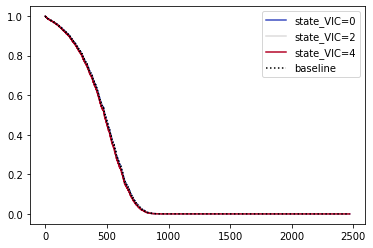

In [18]:
cph.plot_partial_effects_on_outcome('state_VIC', values=np.arange(0, 5, 2), cmap='coolwarm')

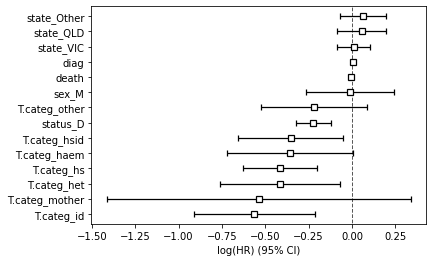

In [19]:
cph.plot()

#Parametric PH and AFT models

In [20]:
from lifelines.datasets import load_rossi

rossi = load_rossi()

# rossi.head()

aft = WeibullAFTFitter()
aft.fit(rossi, duration_col='week', event_col='age')

aft.print_summary(3)

<lifelines.WeibullAFTFitter: fitted with 432 total observations, 0 right-censored observations>
             duration col = 'week'
                event col = 'age'
   number of observations = 432
number of events observed = 432
           log-likelihood = -1614.317
         time fit was run = 2021-07-15 19:29:52 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                         
lambda_ arrest    -0.294      0.746      0.020           -0.334           -0.254                0.716                0.776
        fin       -0.001      0.999      0.017           -0.034            0.032                0.967                1.033
        mar       -0.006      0.994      0.026           -0.057            0.046                0.945                1.047
        paro      -0.006      0.994      0.018           -0.040            0.029                0.961                1.029
        prio      -0.004      0.996      0.003           -0.010            0.002                0.990                1.002
        race      -0.018      0.982      0.026           -0.068            0.032                0.934                1.033
        wexp       0.031      1.032      0.018           -0.004            0.066                0.996                1.068
        Intercept  3.964     52.666      0.033            3.900            4.028               49.392               56.158
rho_    Intercept  1.756      5.791      0.044            1.669            1.843                5.309                6.317

                        z       p   -log2(p)
param   covariate                           
lambda_ arrest    -14.460 <0.0005    155.019
        fin        -0.040   0.968      0.047
        mar        -0.217   0.828      0.272
        paro       -0.322   0.748      0.419
        prio       -1.174   0.240      2.056
        race       -0.711   0.477      1.068
        wexp        1.757   0.079      3.665
        Intercept 121.026 <0.0005        inf
rho_    Intercept  39.607 <0.0005        inf
---
Concordance = 0.935
AIC = 3246.634
log-likelihood ratio test = 174.195 on 7 df
-log2(p) of ll-ratio test = 111.235